# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [44]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
DEVICE = 'cuda:0'
NDIM = 2 # number of parameters
NBINS = 1000
SIGMA = 0.1

In [58]:
# A toy model with a diffuse and point source component

def model(z, sigma = SIGMA):
    X = np.linspace(-40, 40, NBINS)
    mu = np.sin(X)*z[0] + np.cos(X)*z[1]
    n = np.random.randn(*X.shape)*sigma
    return mu + n

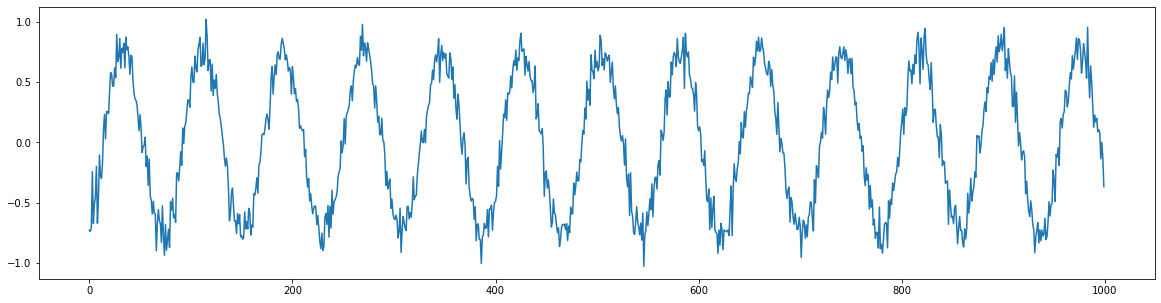

In [59]:
z0 = np.array([0.3, 0.7])
x0 = model(z0)

plt.figure(figsize=(20,5))
plt.plot(x0)

In [60]:
err = SIGMA/np.sqrt(2)/np.sqrt(NBINS)  # 1/sqrt(2) = <sin^2>^(1/2) etc
print("Expected measurement error:", err)

Expected measurement error: 0.00223606797749979


In [61]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(1, 10, 5)
        self.conv2 = torch.nn.Conv1d(10, 20, 5)
        self.conv3 = torch.nn.Conv1d(20, 40, 5)
        self.pool = torch.nn.MaxPool1d(3)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)

        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [93]:
# Instantiate network

sw = swyft.SWYFT(x0, model, zdim = 2, device = DEVICE, head = Head)

In [94]:
sw.run(nrounds = 1, max_epochs = 30, recycle_net = False)

Number of output features: 1400


100%|██████████| 47/47 [00:00<00:00, 215.84it/s]


Constrained posterior volume: 0.183192
Number of output features: 1400


100%|██████████| 47/47 [00:00<00:00, 208.93it/s]


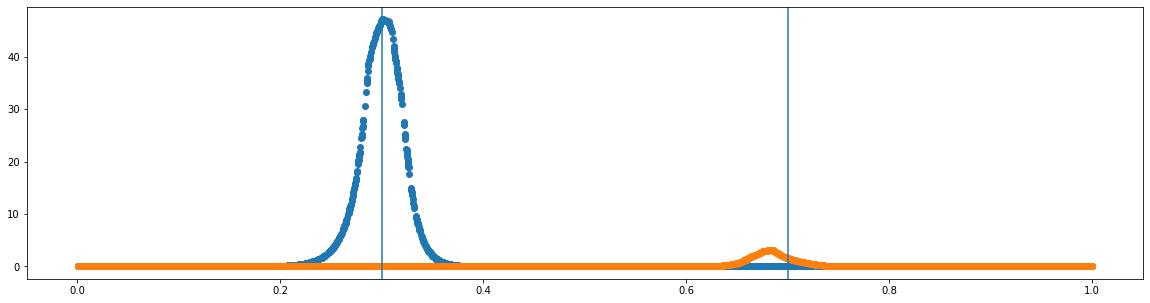

In [101]:
plt.figure(figsize=(20, 5))
for i in range(2):
    zgrid, lnLgrid = sw.posterior(i, version = 0)
    plt.axvline(z0[i])
    plt.scatter(zgrid[:], np.exp(lnLgrid[:]))
    #plt.plot(zgrid[:], stats.norm.pdf(zgrid[:], z0[i], err))

In [8]:
sw.comb([[0, 1]])

Number of output features: 160


100%|██████████| 47/47 [00:00<00:00, 304.11it/s]


(0.0, 1.0)

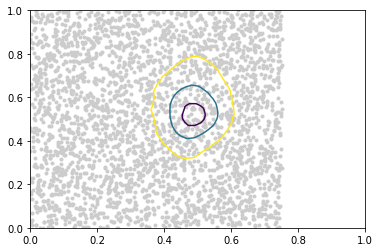

In [9]:
zgrid, lnLgrid = sw.posterior([0, 1])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9])
plt.xlim([0, 1])
plt.ylim([0, 1])